<a href="https://colab.research.google.com/github/chloecasserly/Electrifying-Tractors-for-Farming-and-Electricity-Grid-Integration/blob/main/TractorOptimisationv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# User Input for Optimisation --------------------------------------------------
# Scenario inputs (0 or 1)
pv = 1
bess = 0
capex = 1
fcas = 0

# Prints name to output graphs
name = 'PV'

# Collating csv files




Upload model files

In [2]:
from google.colab import files;
uploaded = files.upload()

"""
Upload the following files for the code to run:

Currently Used
 - 'Model RF Tractor Use.xlsx'
 - 'Model NEM Spot Price Full.xlsx'
 - 'Model TOU Cost ActewAGL 2025.xlsx'
 - 'Model TOU Cost Essential Energy 2025.xlsx'
 - 'Model PV Generation.xlsx'
 - 'Model Electricity Profile V1.xlsx'

Link to all model files
https://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do
"""

Saving Model TOU Cost Essential Energy 2025.xlsx to Model TOU Cost Essential Energy 2025 (2).xlsx
Saving Model Electricity Profile V1.xlsx to Model Electricity Profile V1 (2).xlsx
Saving Model PV Generation.xlsx to Model PV Generation (2).xlsx
Saving Model TOU Cost ActewAGL 2025.xlsx to Model TOU Cost ActewAGL 2025 (2).xlsx
Saving Model NEM Spot Price Full.xlsx to Model NEM Spot Price Full (2).xlsx
Saving Model RF Tractor Use.xlsx to Model RF Tractor Use (2).xlsx


"\nUpload the following files for the code to run:\n\nCurrently Used\n - 'Model RF Tractor Use.xlsx'\n - 'Model NEM Spot Price Full.xlsx'\n - 'Model TOU Cost ActewAGL 2025.xlsx'\n - 'Model TOU Cost Essential Energy 2025.xlsx'\n - 'Model PV Generation.xlsx'\n - 'Model Electricity Profile V1.xlsx'\n\nLink to all model files\nhttps://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do\n"

# Basic Level Optimisation

Simple Retail Price and Tractor Consumption Cost Optimisation

In [3]:
import pandas as pd
from pyomo.environ import *
!apt-get install -y -qq glpk-utils

# Data Import and Processing ---------------------------------------------------

# Load excel files

# Tractor Use (Options A -> D)
# Slashing and Undervine Spraying can be done in 1 day or split over 2 days
# 1 day Slashing and Undervine Spraying
excel_tractor_use_A = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load A', usecols = 'I', header=1)
# 1 day Slashing and 2 days Undervine Spraying
excel_tractor_use_B = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load B', usecols = 'I', header=1)
# 2 days Slashing and 1 day Undervine Spraying
excel_tractor_use_C = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load C', usecols = 'I', header=1)
# 2 days Slashing and 2 days Undervine Spraying
excel_tractor_use_D = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load D', usecols = 'I', header=1)
# Note: header=1 is used as document has two header rows

# Wholesale Electricity Prices (SPOT Prices from NEM)
excel_spot_price = pd.read_excel('Model NEM Spot Price Full.xlsx', usecols='I')

excel_ele_profile = pd.read_excel('Model Electricity Profile V1.xlsx', sheet_name='Total Profile' ,usecols='I')

excel_PV = pd.read_excel('Model PV Generation.xlsx', usecols='I')

# ActewAGL Residential Electricity Costs
# ActewAGL Plan 1 (Home_Plan_Price_Per_kWh)
excel_R_A1 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='C')
# ActewAGL Energy Plan 2 (Home_Time_Of_Use_Plan_Price_Per_kWh)
excel_R_A2 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='D')
# ActewAGL Plan 3 (Home_Daytime_Economy_Plan_Price_Per_kWh)
excel_R_A3 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='E')

# Essential Energy Residential Electricity Costs
# Essential Energy Plan 1 (Residential_Time_Of_Use_Opt_In_Demand_Plan_Price_Per_kWh)
excel_R_E1 = pd.read_excel('Model TOU Cost Essential Energy 2025.xlsx', usecols='C')
# Essential Energy Energy Plan 2 (Residential_Time_Of_Use_Sun_Soaker_Plan_Price_Per_kWh)
excel_R_E2 = pd.read_excel('Model TOU Cost Essential Energy 2025.xlsx', usecols='D')


# Create index of no. data points for set (doesnt need to be based off 'Tractor_Use'
# but all data sets in the optimisation are the same length of data
# points)
data_length = list(range(len(excel_tractor_use_A)))

# CODE CHECKS
print(data_length)
print(excel_tractor_use_A.head())


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Current Optimisation Status Notes:
1. SOC has its own indices to use to calculate based on previous and next values - can see in 0.0
2. Tractor and BESS efficiency data has not been correctly filled (only placeholder)
3. OandM for tractor is also a placeholder
4. CRF has not been coded (this shouldnt be too hard)
5. Grid Capacity needs to be determined possily using the input of a postcode
8. Should write out various scenarios in notes with flags for BESS etc


In [4]:
"""
Structured Optimisation following 'Updated_Optimisation_5.4'
"""
# 0.0 Optimisation Set Up ------------------------------------------------------

# Create Pyomo model "modelv1"
modelv1 = ConcreteModel()
# Make index for days
modelv1.T = Set(initialize=data_length)

# Make index for SOC Constraints that use [t-1] and [t+1]
T_SOC_indices = data_length[:-1]  # all t where t+1 is valid
modelv1.T_SOC = Set(initialize=T_SOC_indices)

In [5]:
"""
Structured Optimisation following 'Updated_Optimisation_5.4'
"""
from pyomo.environ import inequality
# Fixed Variables --------------------------------------------------------------
eff_in = 0.9
eff_out = 0.9
CAPEX_tractor = 155711
CAPEX_PV = 65623
CAPEX_BESS = 29300
OandM_tractor = 25000 # Unsure what this value is and where to find
OandM_PV = 44.198
OandM_BESS = 4.3274
CRF = 0 # Can add later

# 1.0 Variables and Parameters -------------------------------------------------

# 1.1 Decision Variables (Decided by optimisation)
# Status: DONE
# Variables are non-negative and part of indexed set "modelv1.T"
modelv1.grid_imp_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.grid_exp_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.grid_imp_R = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.grid_exp_R = Var(modelv1.T, domain=NonNegativeReals) # kWh

modelv1.BESS_in_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.BESS_out_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.BESS_in_R = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.BESS_out_R = Var(modelv1.T, domain=NonNegativeReals) # kWh

modelv1.tractor_in = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.tractor_out = Var(modelv1.T, domain=NonNegativeReals) # kWh

modelv1.PV_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.PV_R = Var(modelv1.T, domain=NonNegativeReals) # kWh

modelv1.farm = Var(modelv1.T, domain=NonNegativeReals) # kWh

modelv1.SOC_BESS_W = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.SOC_BESS_R = Var(modelv1.T, domain=NonNegativeReals) # kWh
modelv1.SOC_tractor = Var(modelv1.T, domain=NonNegativeReals) # kWh

# 1.2 Model Parameters and Inputs (Should be assigned a value immediately from imported models or elsewhere
# Status: Partially finished - CRF identification
modelv1.PV_cap = Param(initialize=2) # kW (KWp) (doc ref - Model PV Generation)

modelv1.BESS_cap_W = Param(initialize=67.5) # kWh (doc ref - Research Battery BESS Fendt tractor chosen)
modelv1.BESS_cap_R = Param(initialize=67.5) # kWh

modelv1.tractor_cap = Param(initialize=100) #kWh (doc ref - Research Tractor and Battery)

modelv1.BESS_max_W = Param(initialize=105) # kWh (doc ref - Research Battery BESS)
modelv1.BESS_max_R = Param(initialize=75) # kWh

modelv1.tractor_max = Param(initialize=14.28) # kWh (doc ref - Research Battery BESS Fendt tractor chosen)

modelv1.grid_max = Param(initialize=15) # Rohan is collating better data for this

modelv1.tractor_load = Param(modelv1.T, initialize=excel_tractor_use_A) # Tractor Usage Profile A (Can choose A-D)
modelv1.farm_load = Param(modelv1.T, initialize=excel_ele_profile) # Farm Load

modelv1.price_W = Param(modelv1.T, initialize=excel_spot_price) # NEM SPOT Prices
modelv1.price_R = Param(modelv1.T, initialize=excel_R_A1) # ActewAGL Plan 1 used here

modelv1.PV = Param(modelv1.T, initialize=excel_PV) # kWh

# modelv1.CRF = Param() yet to figure out based on research paper

# 1.3 Scenarion Flags (Binary Values)
# Status: DONE
# Flags = 1 indicates using PV,BESS,CAPEX or FCAS
# Scenarios:
# A-PVO - PV Only
# A-BO - BESS Only
# A-PVB - PV and BESS
# ?? - need to write out FCAS scenario in scenario doc
delta_PV = pv
delta_BESS = bess
delta_CAPEX = capex
delta_FCAS = fcas # Not included in this version

# 2.0 Objective Function -------------------------------------------------------
# Status: Partially Done (no FCAS)
# Define Objective in function
# No delta pv or bess included in 5.4 so added here
def obj_rule(m):
    grid_cost = sum(modelv1.price_W[t] * (modelv1.grid_imp_W[t] -
                                          modelv1.grid_exp_W[t]) +
                    modelv1.price_R[t] * (modelv1.grid_imp_R[t] -
                                          modelv1.grid_exp_R[t])- delta_FCAS * (1)
                                          for t in m.T)
# Note: FCAS variables have not been included in this version so are replaced by 1
    return (grid_cost + delta_CAPEX * (CAPEX_tractor + CAPEX_PV + CAPEX_BESS) +
     delta_PV*(OandM_PV * modelv1.PV_cap) + delta_BESS*(OandM_BESS * modelv1.BESS_cap_W)
     + OandM_tractor + CRF)


# Set Model OBJECTIVE function
modelv1.obj = Objective(rule=obj_rule, sense=minimize)


# 3.0 Constraints --------------------------------------------------------------
# These should be based on 1.1 and 1.2

# 3.1 Energy Balance
# Status: DONE
def energy_balance(m, t):
    return (modelv1.grid_imp_W[t] + modelv1.grid_imp_R[t] + modelv1.PV_W[t] +
            modelv1.PV_R[t] + modelv1.BESS_out_R[t] + modelv1.BESS_out_W[t] +
            modelv1.tractor_out[t] == modelv1.farm[t] +
            modelv1.BESS_in_R[t] + modelv1.BESS_in_W[t] + modelv1.grid_exp_W[t]
            + modelv1.tractor_in[t])

modelv1.energy_constraint = Constraint(modelv1.T, rule=energy_balance)

# 3.2 Wholesale System Dynamics
# Status: DONE
def power_exp_balance_W(m, t):
    return modelv1.grid_imp_W[t] + modelv1.PV_W[t] == modelv1.BESS_in_W[t]
modelv1.power_exp_W_constraint = Constraint(modelv1.T, rule=power_exp_balance_W)

def power_imp_balance_W(m, t):
    return modelv1.grid_exp_W[t] == modelv1.BESS_out_W[t]
modelv1.power_imp__W_constraint = Constraint(modelv1.T, rule=power_imp_balance_W)

def battery_soc_W(m, t):
    return (modelv1.SOC_BESS_W[t+1] == modelv1.SOC_BESS_W[t] +
     (eff_in * modelv1.BESS_in_W[t]) - ((1/eff_out)*modelv1.BESS_out_W[t]))
modelv1.battery_soc_W_constraint = Constraint(modelv1.T_SOC, rule=battery_soc_W)

def battery_cap_range_W(m, t):
    return modelv1.SOC_BESS_W[t] <= modelv1.BESS_cap_W
modelv1.battery_cap_range_W_constraint = Constraint(modelv1.T, rule=battery_cap_range_W)

# 3.3 Residential System Dynamics
# Status: DONE
def power_exp_balance_R(m, t):
    return (modelv1.farm[t] + modelv1.grid_exp_R[t] == modelv1.BESS_out_R[t]
            + modelv1.tractor_out[t])
modelv1.power_exp_R_constraint = Constraint(modelv1.T, rule=power_exp_balance_R)

def power_imp_balance_R(m, t):
    return (modelv1.PV_R[t] + modelv1.grid_imp_R[t] == modelv1.BESS_in_R[t]
            + modelv1.tractor_in[t])
modelv1.power_imp_R_constraint = Constraint(modelv1.T, rule=power_imp_balance_R)

def battery_soc_R(m, t):
    return (modelv1.SOC_BESS_R[t+1] == modelv1.SOC_BESS_R[t] +
     (eff_in * modelv1.BESS_in_R[t]) - ((1/eff_out)*modelv1.BESS_out_R[t]))
modelv1.battery_soc_R_constraint = Constraint(modelv1.T_SOC, rule=battery_soc_R)

def battery_cap_range_R(m, t):
    return modelv1.SOC_BESS_R[t] <= modelv1.BESS_cap_R
modelv1.battery_cap_range_R_constraint = Constraint(modelv1.T, rule=battery_cap_range_R)

# 3.4 Tractor Battery SOC Dynamics
# Status: DONE
def tractor_soc(m, t):
    return (modelv1.SOC_tractor[t+1] == modelv1.SOC_tractor[t] +
     (eff_in * modelv1.tractor_in[t]) - ((1/eff_out)*modelv1.tractor_out[t])
     - modelv1.tractor_load[t])
modelv1.tractor_soc_constraint = Constraint(modelv1.T_SOC, rule=tractor_soc)

def tractor_cap_range(m, t):
    return modelv1.SOC_tractor[t] <= modelv1.tractor_cap
modelv1.tractor_cap_range_constraint = Constraint(modelv1.T, rule=tractor_cap_range)

# 3.5 Power Limits
# Status: DONE
def PV_limit(m, t):
    return modelv1.PV_W[t] + modelv1.PV_R[t] == modelv1.PV[t]
modelv1.PV_limit = Constraint(modelv1.T, rule=PV_limit)

def charge_limit_W(m, t):
    return inequality(-1 * modelv1.BESS_max_W, modelv1.BESS_in_W[t] -
                      modelv1.BESS_out_W[t], modelv1.BESS_max_W)
modelv1.charge_limit_W_constraint = Constraint(modelv1.T, rule=charge_limit_W)

def charge_limit_R(m, t):
    return inequality(-1 * modelv1.BESS_max_R, modelv1.BESS_in_R[t] -
                      modelv1.BESS_out_R[t], modelv1.BESS_max_R)
modelv1.charge_limit_R_constraint = Constraint(modelv1.T, rule=charge_limit_R)

def charge_limit_tractor(m, t):
    return inequality(-1 * modelv1.tractor_max, modelv1.BESS_in_W[t] -
                      modelv1.BESS_out_W[t], modelv1.tractor_max)
modelv1.charge_limit_tractor_constraint = Constraint(modelv1.T, rule=charge_limit_tractor)

def grid_limit_imp_tractor(m, t):
    return inequality(0, modelv1.grid_imp_W[t] +
                      modelv1.grid_imp_R[t], modelv1.grid_max)
modelv1.grid_limit_imp_tractor_constraint = Constraint(modelv1.T, rule=grid_limit_imp_tractor)

def grid_limit_exp_tractor(m, t):
    return inequality(0, modelv1.grid_exp_W[t] + modelv1.grid_exp_R[t],
                      modelv1.grid_max)
modelv1.grid_limit_exp_tractor_constraint = Constraint(modelv1.T, rule=grid_limit_exp_tractor)

## Added in as DRAFT - not apart of version 5.4
def farm_load(m, t):
    return modelv1.farm[t] <= modelv1.farm_load[t]
modelv1.farm_load_constraint = Constraint(modelv1.T, rule=farm_load)

def tractor_load(m, t):
    return modelv1.SOC_tractor[t] <= modelv1.tractor_load[t]
modelv1.tractor_load_constraint = Constraint(modelv1.T, rule=tractor_load)


# 3.6 Grid Import/Export Constraints
# Status: TODO


# 3.7 Tractor Usage Constraint
# Status: TODO


# 3.8 FCAS Power Availability
# Status: TODO


# 3.9 FCAS SoC Availability Constraints
# Status: TODO


# 3.10 FCAS Total Capacity Constraint
# Status: TODO



In [6]:
import time
t0 = time.time()
# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(modelv1)

# Output total cost and first few values
print(f'{name} Optimisation complete')
print("Total annual cost: $", round(value(modelv1.obj), 2))
t1 = time.time()
print("Total time to solve optimisation:",(t1-t0),'s')

<function name at 0x7a2f4d92f4c0> Optimisation complete
Total annual cost: $ 268549.37
Total time to solve optimisation: 150.68344354629517 s


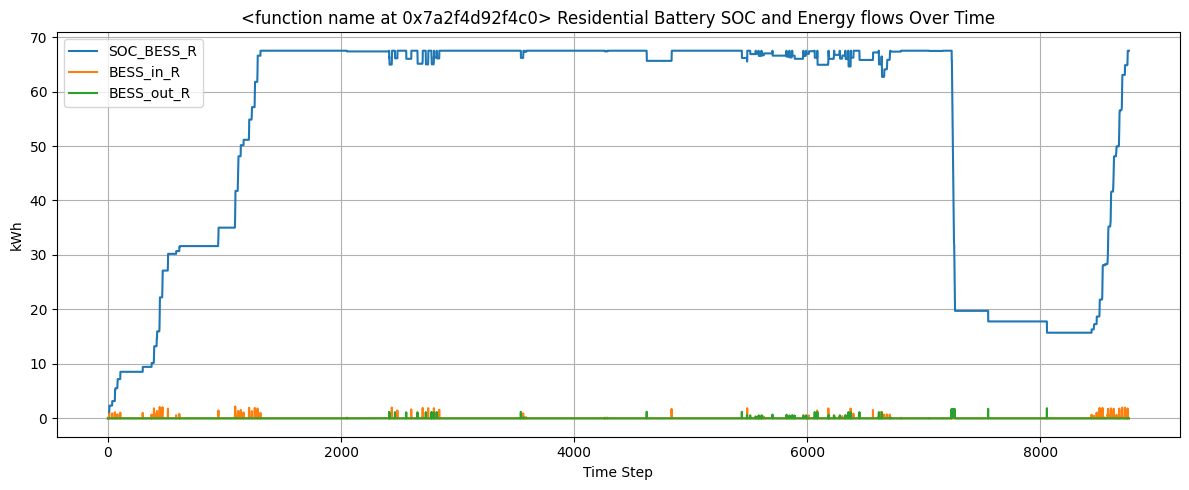

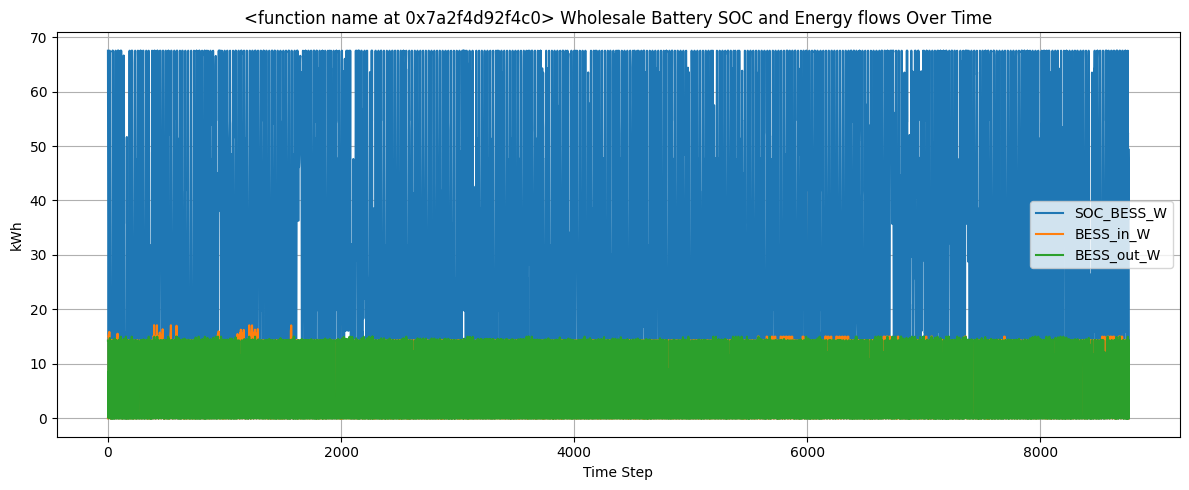

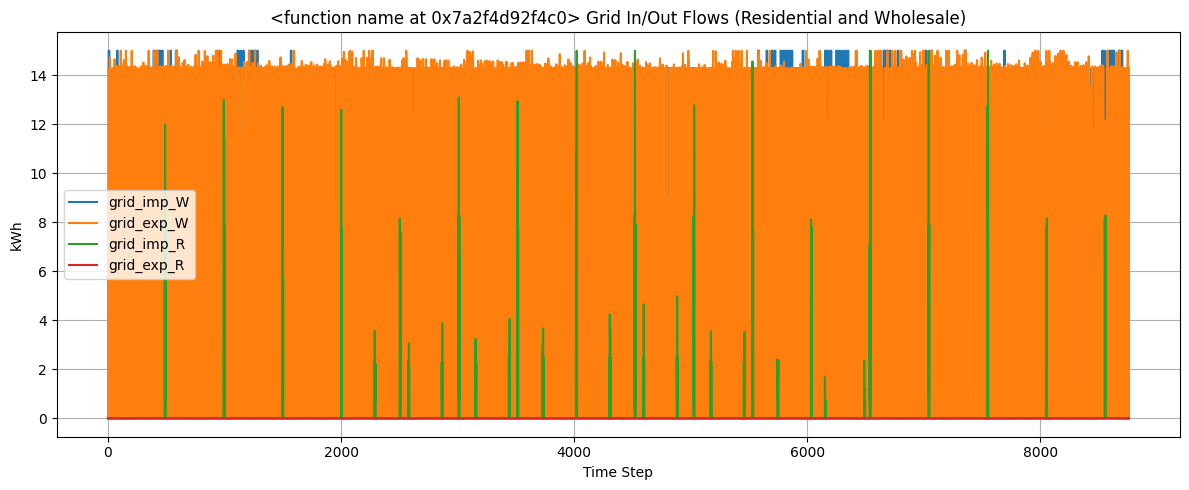

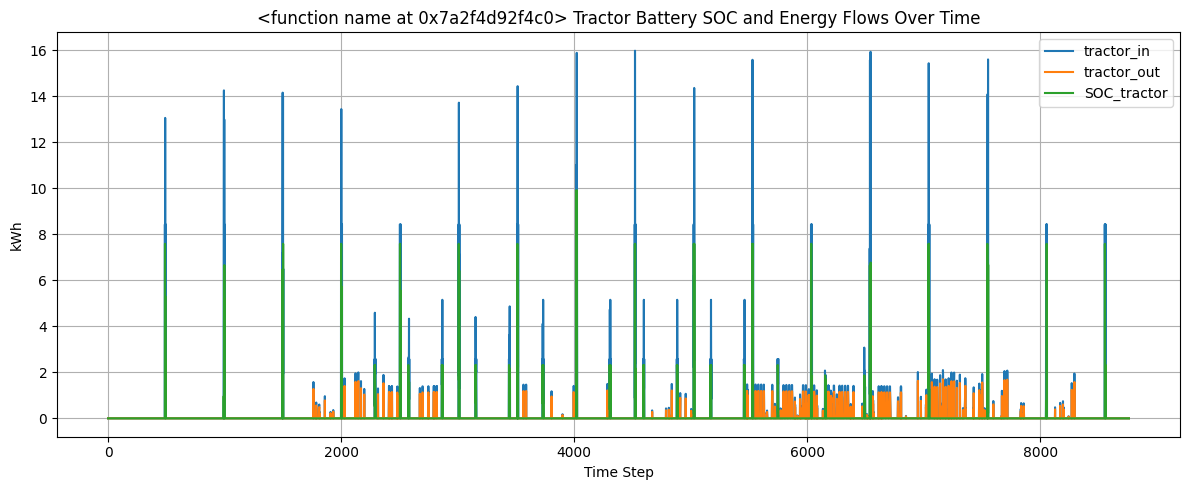

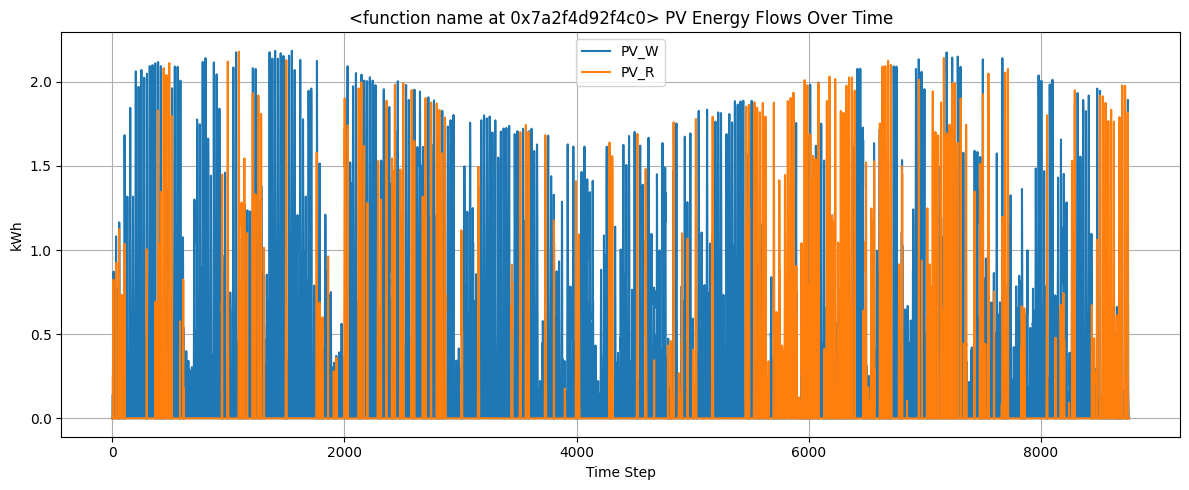

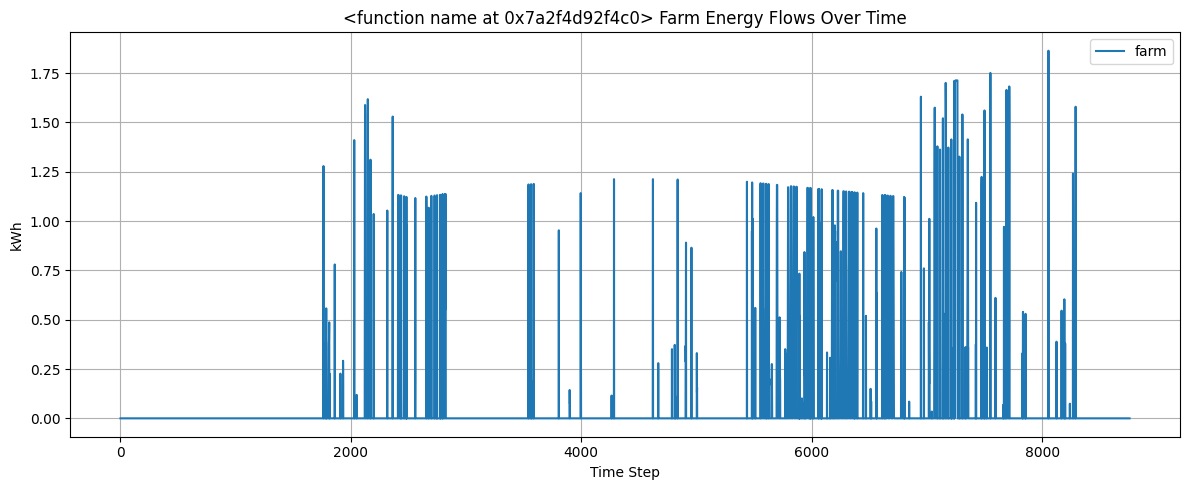

In [7]:
from pyomo.environ import value
import matplotlib.pyplot as plt

# Extract time steps (x-axis)
timesteps = list(modelv1.T)

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.SOC_BESS_R[t]) for t in timesteps], label='SOC_BESS_R')
plt.plot(timesteps, [value(modelv1.BESS_in_R[t]) for t in timesteps], label='BESS_in_R')
plt.plot(timesteps, [value(modelv1.BESS_out_R[t]) for t in timesteps], label='BESS_out_R')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} Residential Battery SOC and Energy flows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.SOC_BESS_W[t]) for t in timesteps], label='SOC_BESS_W')
plt.plot(timesteps, [value(modelv1.BESS_in_W[t]) for t in timesteps], label='BESS_in_W')
plt.plot(timesteps, [value(modelv1.BESS_out_W[t]) for t in timesteps], label='BESS_out_W')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} Wholesale Battery SOC and Energy flows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.grid_imp_W[t]) for t in timesteps], label='grid_imp_W')
plt.plot(timesteps, [value(modelv1.grid_exp_W[t]) for t in timesteps], label='grid_exp_W')
plt.plot(timesteps, [value(modelv1.grid_imp_R[t]) for t in timesteps], label='grid_imp_R')
plt.plot(timesteps, [value(modelv1.grid_exp_R[t]) for t in timesteps], label='grid_exp_R')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} Grid In/Out Flows (Residential and Wholesale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.tractor_in[t]) for t in timesteps], label='tractor_in')
plt.plot(timesteps, [value(modelv1.tractor_out[t]) for t in timesteps], label='tractor_out')
plt.plot(timesteps, [value(modelv1.SOC_tractor[t]) for t in timesteps], label='SOC_tractor')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} Tractor Battery SOC and Energy Flows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.PV_W[t]) for t in timesteps], label='PV_W')
plt.plot(timesteps, [value(modelv1.PV_R[t]) for t in timesteps], label='PV_R')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} PV Energy Flows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(timesteps, [value(modelv1.farm[t]) for t in timesteps], label='farm')
plt.xlabel('Time Step')
plt.ylabel('kWh')
plt.title(f'{name} Farm Energy Flows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

